## Final Project Submission

Please fill out:
* Student name: Kevin Spring
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL:

# Business Problem
Our clients is a real estate broker in King County, WA interested in finding a solution for their clients. Many of their clients come to them needing to sell their home but are unsure of the price to list. The real estate broker wants us to design and implement a model where they can take in the attributes of their clients home and determine which price to begin listing discussion with their client.

## Stakeholders
- President of brokerage firm
- Real estate agents that will use the dashboard

# Summary of Recommendations

# Exploratory Data Analysis and Clean-up

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import and inspect data
df = pd.read_csv('data/kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


## Identify and remove duplicated records

In [4]:
# Any dulplicated homes?
duplicates_len = len(df[df.duplicated(subset=['id'], keep=False)].sort_values(by='id'))
print(f"There are {duplicates_len} duplicated records.")
df[df.duplicated(subset=['id'], keep=False)].sort_values(by='id').head(6)
#df[df['id'] == 1000102]

There are 353 duplicated records.


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2495,1000102,4/22/2015,300000.0,6,3.00,2400,9373,2.0,NO,NONE,...,7 Average,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
2494,1000102,9/16/2014,280000.0,6,3.00,2400,9373,2.0,NaN,NONE,...,7 Average,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
16800,7200179,10/16/2014,150000.0,2,1.00,840,12750,1.0,NO,NONE,...,6 Low Average,840,0.0,1925,0.0,98055,47.4840,-122.211,1480,6969
16801,7200179,4/24/2015,175000.0,2,1.00,840,12750,1.0,NO,NONE,...,6 Low Average,840,0.0,1925,NaN,98055,47.4840,-122.211,1480,6969
11422,109200390,10/20/2014,250000.0,3,1.75,1480,3900,1.0,NO,NONE,...,7 Average,1480,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956
11421,109200390,8/20/2014,245000.0,3,1.75,1480,3900,1.0,NO,NONE,...,7 Average,1480,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956


### Duplicate home ID discussion
The duplicated records based on ID look like they are the same home that wold within the same year as they have the same attributes except for sale `date`. These may be homes that were flipped or sold quickly after. I will keep these records as I am interested in predicting a home's sale price and these sales of the same home can act as replicates improving my model.

In [5]:
# Remove duplicates
#df.drop_duplicates(subset=['id'], keep='first', inplace=True)

## Unnecessary variables
The following variables will be deleted from this analysis as they will not are unnecessary
- `id` - This is an unique identifier for each home. As it is too specific it will be deleted.
- `date` - This is the sale date and is not needed as all the homes were sold between 2014 to 2015.
- `lat` - This is the latitude of the home sold. As it is too specific for the home it will be deleted
- `long` - same reasoning as `lat`

In [6]:
df.drop(['id', 'date', 'lat', 'long'], axis=1, inplace=True)

## Missing data

In [7]:
# How many columns have NaN?
print(df.isna().sum())

#df[df.isnull().any(axis=1)].head()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64


In [8]:
# Any placeholders?
# Look for top occuring values
print('King County, WA \n Home Sales Dataframe\n')
for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize = True).head(10), '\n')

King County, WA 
 Home Sales Dataframe

price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
325000.0    0.006853
400000.0    0.006714
375000.0    0.006390
300000.0    0.006158
525000.0    0.006066
Name: price, dtype: float64 

bedrooms 
 3     0.454878
4     0.318655
2     0.127796
5     0.074131
6     0.012594
1     0.009075
7     0.001760
8     0.000602
9     0.000278
10    0.000139
Name: bedrooms, dtype: float64 

bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
1.50    0.066907
2.75    0.054869
3.00    0.034866
3.50    0.033847
3.25    0.027272
Name: bathrooms, dtype: float64 

sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
1800    0.005973
1820    0.005927
1480    0.005788
1720    0.005788
1540    0.005742
Name: sqft_living, dtype: float64 

sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
750

### Missing value results
- `NaN`
    - `waterfront`
    - `view`
    - `yr_renovated`
- Placeholder
    - `yr_renovated` has `0` for missing or unknown values.
    - `sqft_basement` has `?` for missing or unknown values.

### Strategy for replaceing missing values
- `waterfront`
    - Binary categorical variable (`YES` or `NO`)
    - replace `NaN` with mode of `NO` as most likely these properties are not waterfront.
- `yr_renovated`
    - Catagorical variable
    - `0` is the most common value with over 95% of values. 
    - Replace `NaN` with 0 value
- `view`
    - Ordinal categorical variable
    - replace `NaN` with `NONE` 

In [9]:
# replacing waterfront NaN with 'NO'
df['waterfront'].fillna('NO', inplace=True)

# replace yr_renovated NaN with 'Unknown'
df['yr_renovated'].fillna(0, inplace=True)

# replace `Nan` with `NONE` for column `view`
df['view'].fillna('NONE', inplace=True)

In [10]:
# How many columns have NaN?
print(df.isna().sum())

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64


### Strategy for data cleanup
- `condition`
    - Ordinal categorical variable
    - dictionary - `{'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}`
- `grade`
    - Ordinal categorical variable
    - Example: `7 Average`
    - Delete the descriptor, keep the number, and convert it to `int` datatype.
- `sqft_basement`
    - continuous variable
    - `?` makes up about 2% of values and the current value of `0` makes up almost 60%.
    - Since it is a low value I will replace `?` with the mode of `0`.
- `view`
    - Oridinal catagorical variable
    - dicitonary - `{'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}`
- `waterfront`
    - Binary catagorical variable
    - dictionary - `'NO': 0, 'YES': 1`
- `home_age`
    - Create new catagorical variable
    - subtract current year from `yr_built`
    - Drop `yr_built`
- `yr_since_reno`
    - Make new variable  
    - Subtract current year from `yr_renovated`
        -  `0` is the most common value with over 95% of values.
        - if never renovated then subtract from `yr_built`
    - Drop `yr_renovated`

In [11]:
from datetime import date

# condition: Map condition variable to dictionary
condition_dict = {'Poor': 0, 'Fair': 1, 'Average': 2, 
                  'Good': 3, 'Very Good': 4}
df['condition'] = df['condition'].map(condition_dict)

# grade: strip out by spaces and keep the first string, which should be the number
df['grade'] = df['grade'].apply(lambda x: x.split(' ', 1)[0]).astype(int)

# sqft_basement has '?' as a placeholder. Set this to 0.
df['sqft_basement'].replace('?', 0, inplace=True)
df['sqft_basement'] = df['sqft_basement'].astype(float)
#print('Removed ? as placeholder:', len(df.loc[df['sqft_basement'] == '?', 'sqft_basement']))

# view: Map condition variable to dictionary
view_dict = {'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 
                  'GOOD': 3, 'EXCELLENT': 4}
df['view'] = df['view'].map(view_dict)
df.head()

# waterfront: Map binary variable to dictionary
waterfront_dict = {'NO': 0, 'YES': 1}
df['waterfront'] = df['waterfront'].map(waterfront_dict)

# home_age 
current_year = date.today().year
df['home_age'] = current_year - df['yr_built']
df.drop('yr_built', axis=1, inplace=True)

# yr_since_reno
# subtraction function
def sub(a, b):
    return a - b

df['yr_since_reno'] = df.apply(lambda row : sub(current_year, row['yr_renovated']) if row['yr_renovated'] > 0 else row['home_age'], axis = 1)
df.drop('yr_renovated', axis=1, inplace=True)
# inspect 
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,home_age,yr_since_reno
0,221900.0,3,1.00,1180,5650,1.0,0,0,2,7,1180,0.0,98178,1340,5650,67,67.0
1,538000.0,3,2.25,2570,7242,2.0,0,0,2,7,2170,400.0,98125,1690,7639,71,31.0
2,180000.0,2,1.00,770,10000,1.0,0,0,2,6,770,0.0,98028,2720,8062,89,89.0
3,604000.0,4,3.00,1960,5000,1.0,0,0,4,7,1050,910.0,98136,1360,5000,57,57.0
4,510000.0,3,2.00,1680,8080,1.0,0,0,2,8,1680,0.0,98074,1800,7503,35,35.0
5,1230000.0,4,4.50,5420,101930,1.0,0,0,2,11,3890,1530.0,98053,4760,101930,21,21.0
6,257500.0,3,2.25,1715,6819,2.0,0,0,2,7,1715,0.0,98003,2238,6819,27,27.0
7,291850.0,3,1.50,1060,9711,1.0,0,0,2,7,1060,0.0,98198,1650,9711,59,59.0
8,229500.0,3,1.00,1780,7470,1.0,0,0,2,7,1050,730.0,98146,1780,8113,62,62.0
9,323000.0,3,2.50,1890,6560,2.0,0,0,2,7,1890,0.0,98038,2390,7570,19,19.0


In [12]:
# Convert necessary variables to categorical
#cat_col = ['waterfront', 'bedrooms', 'bathrooms', 'floors', 'view', 
#           'condition', 'grade', 'zipcode', 'home_age', 'yr_since_reno']

# label columns as category
#df[cat_col] = df[cat_col].astype('category')
#df.info()

In [13]:
# Change id, zipcode, lat, long to string
#df.describe(include = 'object')

## Charts to check distribution of variables

In [14]:
#pd.plotting.scatter_matrix(df,figsize  = [12, 12]);
#plt.show()

In [15]:
# Correlation with price
#import matplotlib.pyplot as plt
#%matplotlib inline

X = df.copy()
X.drop(['price'], axis=1, inplace=True)
y = df['price']

#fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 8))
#fig.set_tight_layout(True)

#for index, col in enumerate(X.columns):
#    ax = axes[index//3][index%3]
#    ax.scatter(X[col], y, alpha=0.2)
#    ax.set_xlabel(col)
#    ax.set_ylabel("price")

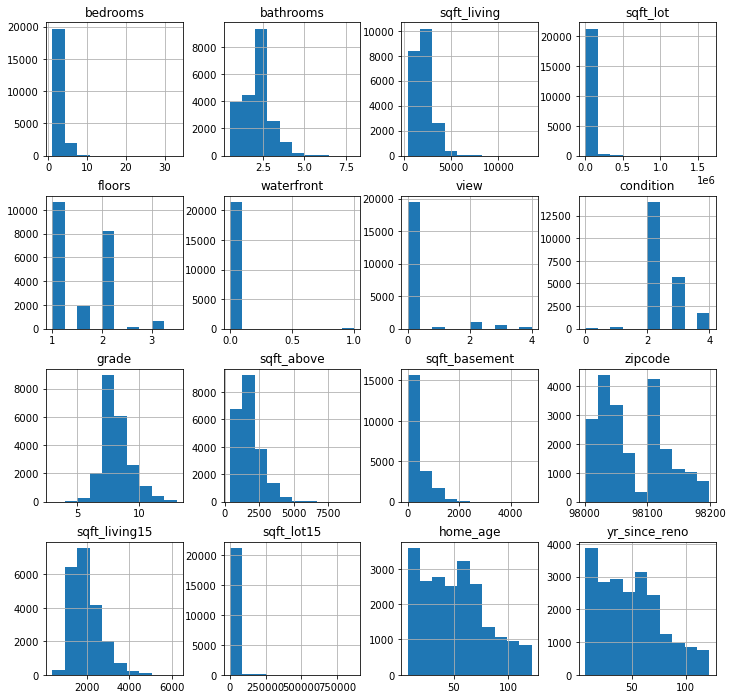

In [16]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
X.hist(ax = ax);

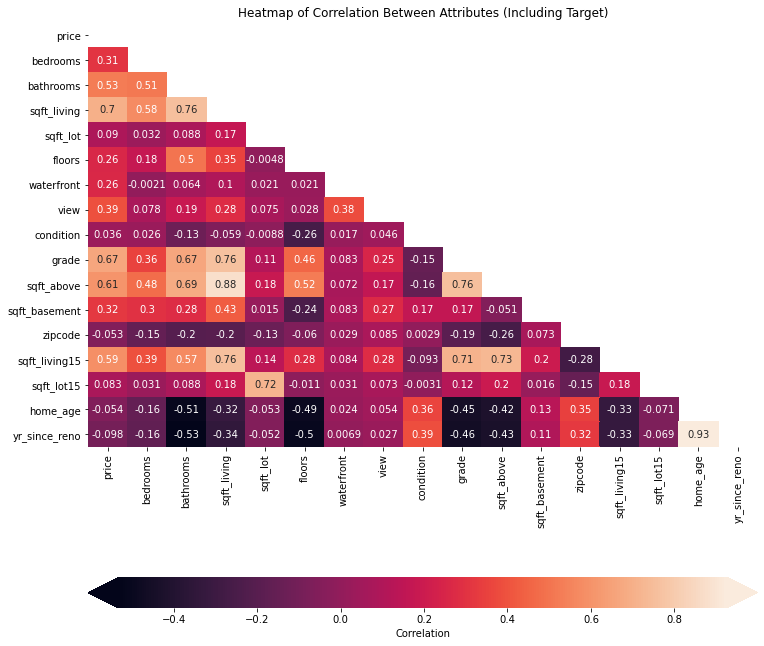

In [17]:
# Make heatmap 
# Run this cell without changes

import seaborn as sns
import numpy as np

# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

## Standardize and Normalize data
https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94



### Strategy for standardization
- Min-max standardization
    


### Strategy for normalization
- Log transform
    - `price`
    - `sqft_living`
    - `sqft_above`
    - `sqft_basement`
    - `sqft_lot`
    - `sqft_living15
    - `sqft_log15`

### Price data

Skewness: 4.023365
Kurtosis: 34.541359


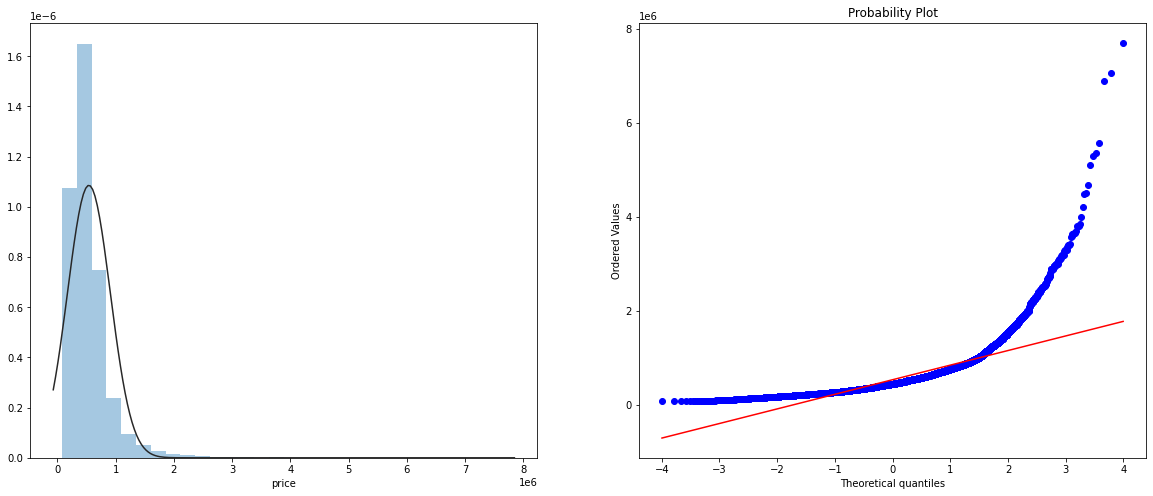

In [18]:
from scipy.stats import norm
from scipy import stats

#histogram and normal probability plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.distplot(df['price'], fit=norm, bins=30, kde=False, ax=ax1);
res = stats.probplot(df['price'], plot=ax2)

# This shows a right-skewed distribution
## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df['price'].skew()) # Data is highly skewed
print("Kurtosis: %f" % df['price'].kurt()) # leptokurtic (>3)

# Notes: I want to put these plots next to each other

Skewness: 0.431004
Kurtosis: 0.691049


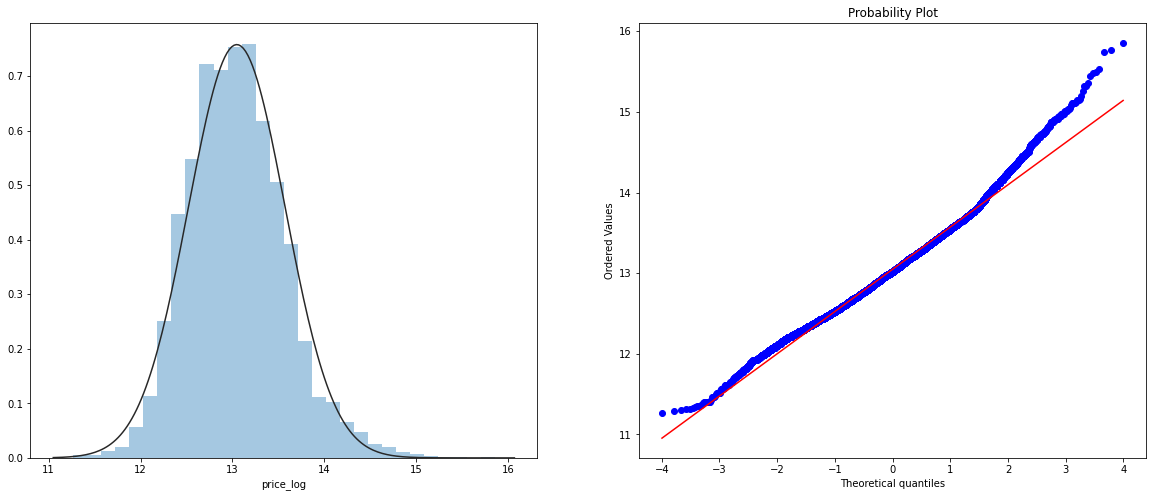

In [19]:
# log transform price data
df['price_log'] = np.log(df['price'])

#histogram and normal probability plot for log transformed price data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.distplot(df['price_log'], fit=norm, bins=30, kde=False, ax=ax1);
res = stats.probplot(df['price_log'], plot=ax2)

# This shows a right-skewed distribution
## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df['price_log'].skew()) # Data is not skewed
print("Kurtosis: %f" % df['price_log'].kurt()) # platykurtic (Kurtosis <3) distribution

### Transform sqft_living

In [20]:
#from sklearn.preprocessing import MinMaxScaler

# Select cols to normalize
#to_normalize = ["sqft_living", "sqft_lot", "sqft_lot15", "sqft_living15", "sqft_basement", "sqft_above"]

#mms = MinMaxScaler()

#df[to_normalize] = pd.DataFrame(
#    mms.fit_transform(df[to_normalize]), columns=to_normalize
#)

#df[to_normalize].hist(figsize=(14, 5));

Skewness: 1.473215
Kurtosis: 5.252102


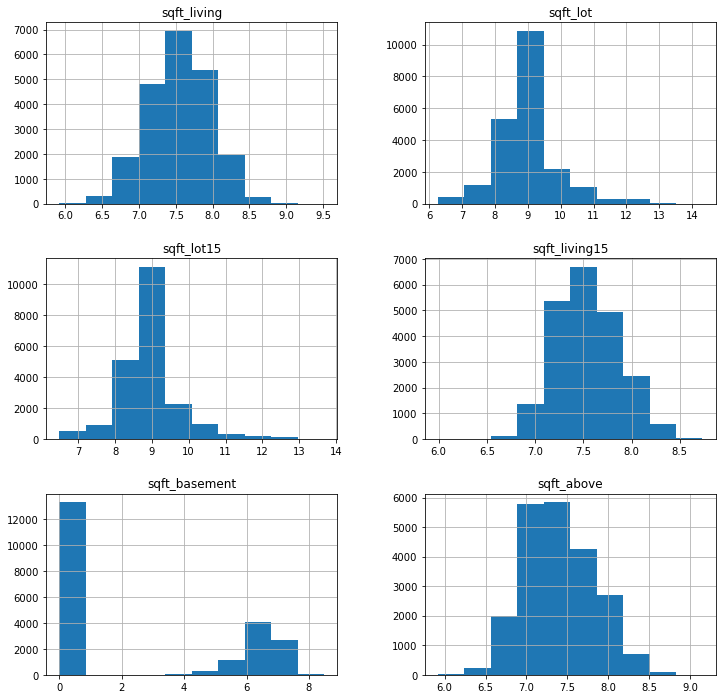

In [21]:
from sklearn.preprocessing import PowerTransformer

# Transform the rest of the continuous right-skewed variables
to_log = ["sqft_living", "sqft_lot", "sqft_lot15", "sqft_living15", "sqft_basement", "sqft_above"]
    
df_to_log = np.log(df[to_log].copy() + 1)

fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df_to_log.hist(ax = ax);

#histogram and normal probability plot
#sns.distplot(df['sqft_living'], fit=norm, bins=30, kde=False);
#fig = plt.figure()
#res = stats.probplot(df['sqft_living'], plot=plt)

# This shows a right-skewed distribution
## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df['sqft_living'].skew()) # Data is skewed
print("Kurtosis: %f" % df['sqft_living'].kurt()) # leptokurtic (>3)

### Log Transformation results
Price and sqft of the home can be normalized with log transformation except for `sqft_basement` which has many 0 values becuase some homes do not have a basement. This variable will be dropped.

In [27]:
df.drop('sqft_basement', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21597 non-null  float64
 1   bedrooms         21597 non-null  int64  
 2   bathrooms        21597 non-null  float64
 3   sqft_living      21597 non-null  int64  
 4   sqft_lot         21597 non-null  int64  
 5   floors           21597 non-null  float64
 6   waterfront       21597 non-null  int64  
 7   view             21597 non-null  int64  
 8   condition        21597 non-null  int64  
 9   grade            21597 non-null  int64  
 10  sqft_above       21597 non-null  int64  
 11  zipcode          21597 non-null  int64  
 12  sqft_living15    21597 non-null  int64  
 13  sqft_lot15       21597 non-null  int64  
 14  home_age         21597 non-null  int64  
 15  yr_since_reno    21597 non-null  float64
 16  price_log        21597 non-null  float64
 17  sqft_living_

In [22]:
#df['sqft_basement'].describe()
np.log(1)

0.0

In [23]:
# Split data into train and test data
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

#X = df.copy()
#X.drop(['price'], axis=1, inplace=True)
#y = df['price']

# Set up the colnames
to_scale = ["home_age", "yr_since_reno", "bedrooms", "bathrooms", "floors"]
to_log = ["price", "sqft_living", "sqft_lot", "sqft_lot15", "sqft_living15",
         "sqft_basement", "sqft_above"]
#categorical = X.select_dtypes(include="category").columns
#categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) #75% training

# Init


#from sklearn.linear_model import LinearRegression
#reg = LinearRegression()
#reg.fit(X_train, y_train)

#accuracy = reg.score(X_test, y_test)
#"Accuracy: {}%".format(int(round(accuracy * 100)))



Skewness: -0.027362
Kurtosis: -0.079038


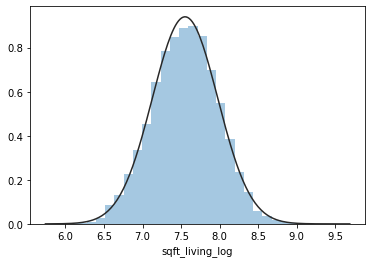

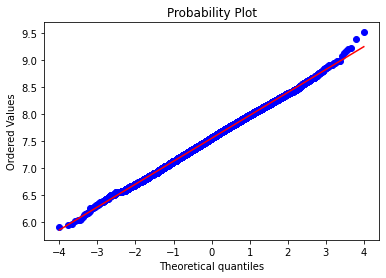

In [24]:
df['sqft_living_log'] = np.log(df['sqft_living'])

#histogram and normal probability plot
sns.distplot(df['sqft_living_log'], fit=norm, bins=30, kde=False);
fig = plt.figure()
res = stats.probplot(df['sqft_living_log'], plot=plt)

# This shows a right-skewed distribution
## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df['sqft_living_log'].skew()) # Data is skewed
print("Kurtosis: %f" % df['sqft_living_log'].kurt()) # leptokurtic (>3)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21597 non-null  float64
 1   bedrooms         21597 non-null  int64  
 2   bathrooms        21597 non-null  float64
 3   sqft_living      21597 non-null  int64  
 4   sqft_lot         21597 non-null  int64  
 5   floors           21597 non-null  float64
 6   waterfront       21597 non-null  int64  
 7   view             21597 non-null  int64  
 8   condition        21597 non-null  int64  
 9   grade            21597 non-null  int64  
 10  sqft_above       21597 non-null  int64  
 11  sqft_basement    21597 non-null  float64
 12  zipcode          21597 non-null  int64  
 13  sqft_living15    21597 non-null  int64  
 14  sqft_lot15       21597 non-null  int64  
 15  home_age         21597 non-null  int64  
 16  yr_since_reno    21597 non-null  float64
 17  price_log   

## Transform Categorical factors to dummy variables

In [26]:
# Convert to Dummy variables
# test
cat_col = ['waterfront', 'bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 
           'yr_built', 'yr_renovated', 'zipcode']

# label columns as category
df[cat_col] = df[cat_col].astype('category')

one_hot_encoder_df = pd.get_dummies(df[cat_col].copy())

one_hot_encoder_df.info()

# extract continunous features from original df
num_col = df.select_dtypes(include='number')

# merge both num_col and one_hot_encoder_df


KeyError: "['yr_built', 'yr_renovated'] not in index"

In [ ]:
# Split data into train-test-split

y = df['price_log']
X = df.drop(['price', 'price_log', 'sqft_living'], axis=1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)


plt.scatter(X['sqft_living_log'], y)

In [ ]:
# Make linear model 
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train, y_train)
